In [45]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

from utils import get_fall_dataset, preprocess_df

In [46]:
dataset = Path('WEDA-FALL/dataset/50Hz')

In [47]:
walking_dataset = dataset / 'D01'
walking_accel = (f for f in walking_dataset.glob('*_accel.csv') if 'vertical' not in f.name)
walking_gyro = walking_dataset.glob('*_gyro.csv')

In [48]:
jogging_dataset = dataset / 'D02'
jogging_accel = (f for f in jogging_dataset.glob('*_accel.csv') if 'vertical' not in f.name)
jogging_gyro = jogging_dataset.glob('*_gyro.csv')

In [49]:
df_list = []
for acc, gyro in zip(walking_accel, walking_gyro):
	df1 = pd.read_csv(acc)
	df2 = pd.read_csv(gyro)
	df = pd.concat([df1, df2], axis=1)
	df = preprocess_df(df).dropna()
	df['label'] = np.full(len(df), 'walking')
	df_list.append(df)
df_walking = pd.concat(df_list)

In [50]:
df_list = []
for acc, gyro in zip(jogging_accel, jogging_gyro):
	df1 = pd.read_csv(acc)
	df2 = pd.read_csv(gyro)
	df = pd.concat([df1, df2], axis=1)
	df = preprocess_df(df).dropna()
	df['label'] = np.full(len(df), 'jogging')
	df_list.append(df)
df_jogging = pd.concat(df_list)

In [51]:
df_fall = get_fall_dataset(dataset)
df_fall = df_fall[df_fall['label'] == 'fall']

df = pd.concat([df_walking, df_jogging, df_fall]).reset_index(drop=True)
# df = pd.concat([df_walking, df_jogging]).reset_index(drop=True)

In [52]:
X = df[['acceleration', 'rotationrate', 'angle_pitch']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [53]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fall       0.58      0.88      0.70      9772
     jogging       0.80      0.69      0.74      7363
     walking       0.97      0.66      0.78     12224

    accuracy                           0.74     29359
   macro avg       0.79      0.74      0.74     29359
weighted avg       0.80      0.74      0.74     29359



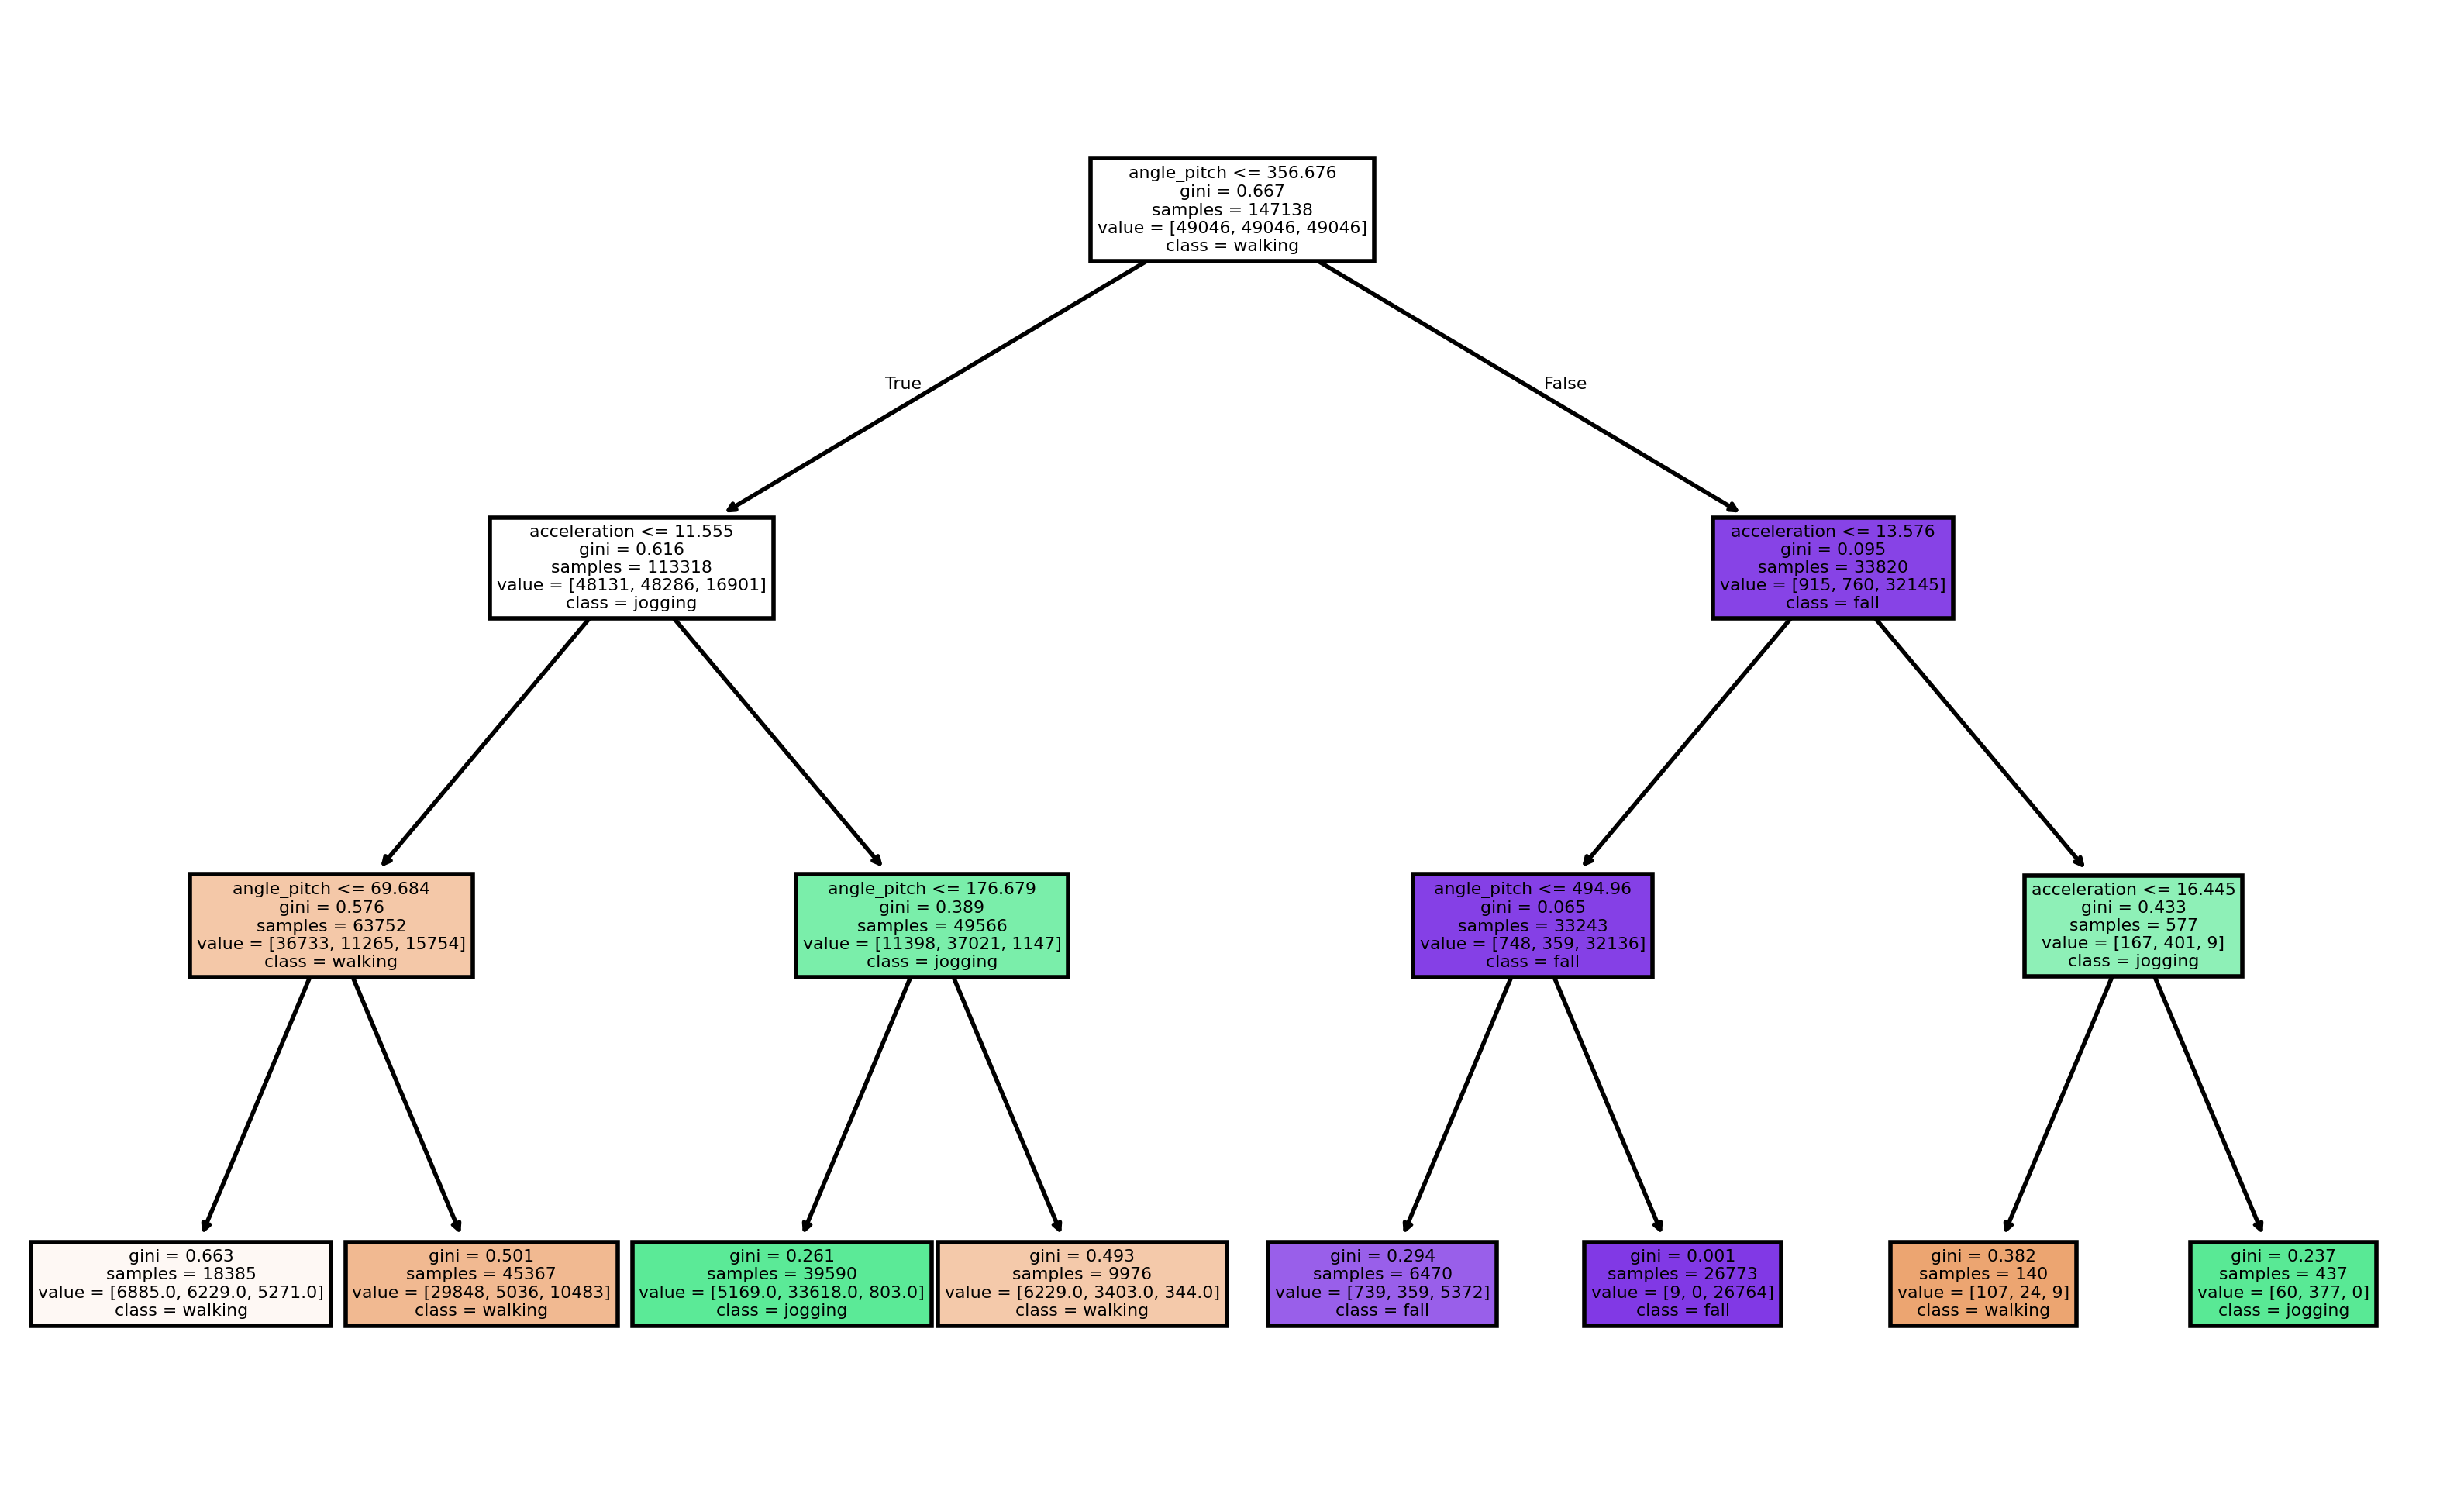

In [54]:
plt.figure(figsize=(10, 6), dpi=400)
plot_tree(clf, feature_names=X.columns, class_names=y.unique(), filled=True)
plt.show()

In [55]:
# Extract rules
c_features = tree_to_rules(clf, X.columns)
print_rules(c_features)

Rules for class fall:
  - angle_pitch <= 69.68 and acceleration <= 11.55
  - angle_pitch > 69.68 and angle_pitch <= 356.68 and acceleration <= 11.55
  - angle_pitch > 176.68 and angle_pitch <= 356.68 and acceleration > 11.55
  - angle_pitch > 494.96 and acceleration > 13.58 and acceleration <= 16.44

Rules for class jogging:
  - angle_pitch > 69.68 and angle_pitch <= 176.68 and acceleration > 11.55
  - angle_pitch > 494.96 and acceleration > 16.44

Rules for class walking:
  - angle_pitch > 356.68 and angle_pitch <= 494.96 and acceleration > 11.55 and acceleration <= 13.58
  - angle_pitch > 494.96 and acceleration > 11.55 and acceleration <= 13.58

